# 목차

### 1. 텍스트 수집
- [1-1. 검색어 입력 및 API 불러오기](#1-1.-검색어-입력-및-API-불러오기)
- [1-2. 검색 결과에서 실제 뉴스 가져오기](#1-2.-검색-결과에서-실제-뉴스-가져오기)
- [1-3. 뉴스 본문 가져오기](#1-3.-뉴스-본문-가져오기)
- [1-4. 수집한-데이터-dataframe으로-제작](#1-4.-수집한-데이터-dataframe으로-제작)
- [1-5. 키워드/날짜/데이터수 데이터 수집](#1-5.-키워드/날짜/데이터수-데이터-수집)
- [1-6. 최종 데이터](#1-6.-최종-데이터)


### 2. 텍스트 전처리
- [2-1. Cleaning](#2-1.-Cleaning)
- [2-2. Checking Morphs & Pos Tagging](#2-2.-Checking-Morphs-&-Pos-Tagging)
- [2-3. Normalization](#2-3.-Normalization)
- [2-4. Stopword Remove](#2-4.-Stopword-Remove)
- [2-5. 전처리 완료 후 데이터 프레임 생성](#2-5.-전처리-완료-후-데이터-프레임-생성)


### 3. 텍스트 분석
- [3-1. WordCloud & 빈도chart](#3-1.-WordCloud-&-빈도chart)
- [3-2. Text Classification](#3-2.-Text-Classification)
- [3-3. Similar document retrieval](#3-3.-Similar-document-retrieval)
- [3-4. Topic Modeling(LDA)](#3-4.-Topic-Modeling(LDA))

# 1. 텍스트 수집

In [1]:
import os
import sys
import time
import urllib.request
import datetime
import time
import json
from bs4 import BeautifulSoup
import pandas as pd
import re
from tqdm import tqdm
from nltk.tokenize import TreebankWordTokenizer
from sklearn.model_selection import train_test_split

### 1-1. 검색어 입력 및 API 불러오기

In [1]:
#delvelopers_1
client_id = 'RWuRpSQWzKGXVmEEjFa3'
client_secret = 'ed44ctBboJ'

In [ ]:
#Naver OpenAPI 사용해서 기본 URL설정
base_url = 'https://openapi.naver.com/v1/search/news.json'
#검색할 키워드 입력
query = input('검색할 키워드를 입력해주세요 : ') 
#검색어를 UTF-8형식으로 인코딩
encQuery = urllib.parse.quote(query.encode('utf-8')) 
#페이지당 10개의 기사 표시
n_display = 10
#날짜순으로 내림차순 정렬
sort = 'date' 
search_result_li = []

#for문 루프를 사용하여 검색결과 100페이지 반복
for start in range(1,992,10): #1~100페이지
    #검색어, 디스플레이, 스타트, 정렬 매개 변수를 기본 URL에 추가하여 새로운 URL생성
    url = f'{base_url}?query={encQuery}&display={n_display}&start={start}&sort={sort}'
    #Naver OpenAPI서버에 HTTP요청 보냄
    my_request = urllib.request.Request(url)
    my_request.add_header("X-Naver-Client-Id",client_id)
    my_request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(my_request)
    rescode = response.getcode()
    
    #HTTP응답 상태 코드가 성공을 나타내면 본문 읽고 문자열로 디코딩
    if(rescode==200):
        response_body = response.read()
    else:
        print("Error Code:" + rescode)
    search_result_str = response_body.decode('utf-8')
    #JSON형식의 검색 결과를 구문 분석하고 search_result_li리스트에 추가
    search_results = json.loads(search_result_str)
    search_result_li.append(search_results)
# print(search_result_li)

### 1-2. 검색 결과에서 실제 뉴스 가져오기

In [70]:
# 태그를 지우는 함수
def remove_tag(my_str):
    p = re.compile('(<([^>]+)>)')
    return p.sub('', my_str)

# 특수문자를 나타내는 &apos;, &quot를 실제 특수문자로 변환
def sub_html_special_char(my_str):
    p1 = re.compile('&lt;')
    p2 = re.compile('&gt;')
    p3 = re.compile('&amp;')
    p4 = re.compile('&apos;')
    p5 = re.compile('&quot;')

    result = p1.sub('\<', my_str)
    result = p2.sub('\>', result)
    result = p3.sub('\&', result)
    result = p4.sub('\'', result)
    result = p5.sub('\"', result)
    return result

In [71]:
# 네이버 뉴스 링크가 있는 뉴스만 추출
titles_li = []
links_li = []
pubdates_li = []

#for문 루프를 돌면서 각 검색 결과(search_result_li)의 항목(item)을 하나씩 접근
for result in search_result_li:
    titles = []
    links = []
    pubdates = []
    #각 항목(item)의 링크(link)가 https://n.news.naver.com/로 시작하는 경우에만 추출
    p = re.compile('https://n.news.naver.com/.+')
    for item in result['items']:
        if p.match(item['link']):
            title = sub_html_special_char(remove_tag(item['title']))
            link = item['link']
            pubdate = item['pubDate']
            titles.append(title)
            links.append(link)
            pubdates.append(pubdate)
    titles_li += titles
    links_li += links
    pubdates_li += pubdates
print('뉴스 개수 :' ,len(links_li))

뉴스 개수 : 454


### 1-3. 뉴스 본문 가져오기

In [72]:
#뉴스 기사 본문을 포함하는 div태그의 id속성값 나타내는 리스트
article_ids = ['newsct_article', 'articeBody']
contents = []

#for문을 돌면서 links_li에 있는 link에 대해 해당 페이지를 BeautifulSoup 이용해 파싱
for link in tqdm(links_li):
    html = urllib.request.urlopen(link)
    bs_obj = BeautifulSoup(html, 'html.parser')
    #contents에 본문 추가하고 artice_ids에 다음 id를 찾기 위해 for문 반복
    for article_id in article_ids:
        content = bs_obj.find_all('div', {'id':article_id})
        if len(content) > 0:
            contents.append(content[0].text)
            break
        else:
            continue
    #하나의 사이트 접속할때마다 3초의 시간, 연속적으로 해서 block당하는 걸 막기위해서 시차를 줘야함
#    time.sleep(3)    

100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [01:39<00:00,  4.56it/s]


### 1-4. 수집한 데이터 dataframe으로 제작

In [73]:
result_dict = {'pub_date':pubdates_li,'title': titles_li, 'link': links_li, 
               'content': contents}
df = pd.DataFrame.from_dict(result_dict)
df['search_word'] = query
df.head()

,pub_date,title,link,content,search_word
0,"Thu, 18 May 2023 02:47:00 +0900","GH, 올해 첫 ‘ESG경영위원회’ 개최",https://n.news.naver.com/mnews/article/030/000...,\n\n\n\n\n\n경기주택도시공사 전경경기주택도시공사(GH·사장 김세용)는 최근...,채권
1,"Thu, 18 May 2023 01:38:00 +0900","""구제해야"" 하더니…'보증금' 챙긴 라덕연 가족",https://n.news.naver.com/mnews/article/055/000...,\n\n\t\t\t<앵커>주가폭락사태의 핵심인물인 라덕연 대표가 구속되기 직전 진범...,채권
2,"Thu, 18 May 2023 01:07:00 +0900","화이자, 씨젠 인수 자금으로 310억 달러 규모 채권 발행",https://n.news.naver.com/mnews/article/215/000...,\n\n\n\n\n\n화이자는 시젠 인수 자금을 조달하기 위해 310억 달러 규모 ...,채권
3,"Thu, 18 May 2023 00:04:00 +0900","[김남국 코인 파문 \<하\>] 2년 전 '김남국 방지법' 발의 신영대 ""아쉽다…""",https://n.news.naver.com/mnews/article/629/000...,"\n\n""가상자산 전수조사 동의…공직자, 재산증식에 무관심해야""""정치적 공격 소재 ...",채권
4,"Thu, 18 May 2023 00:01:00 +0900","[김남국 코인 파문 \<상\>] 수년간 시간 끈 국회…""법 개정 안 할 수 없게 돼""",https://n.news.naver.com/mnews/article/629/000...,"\n\n가상자산 신고와 관련 '공직자윤리법' 12건 계류 중""법안 처리하지 않으면 ...",채권


### 1-5. 키워드/날짜/데이터수 데이터 수집

In [ ]:
### 5월15일 데이터 수집
# df.to_csv('./data/부동산_5월15일_480개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/전세_5월15일_573개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/월세_5월15일_522개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/아파트_5월15일_571개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/대출_5월15일_461개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/주식_5월15일_521개.csv', index=False, encoding='utf-8-sig')
#df.to_csv('./data/채권_5월15일_416개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/코스피_5월15일_459개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/금리_5월15일_437개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/투자_5월15일_368개.csv', index=False, encoding='utf-8-sig')

In [9]:
### 5월16일 데이터 수집
# df.to_csv('./data/부동산_5월16일_449개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/전세_5월16일_477개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/월세_5월16일_512개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/아파트_5월16일_393개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/대출_5월16일_418개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/주식_5월16일_431개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/채권_5월16일_412개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/코스피_5월16일_451개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/금리_5월16일_387개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/투자_5월16일_445개.csv', index=False, encoding='utf-8-sig')

In [77]:
### 5월17일 데이터 수집
# df.to_csv('./data/부동산_5월17일_447개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/전세_5월17일_536개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/월세_5월17일_495개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/아파트_5월17일_394개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/대출_5월17일_468개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/주식_5월17일_419개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/채권_5월17일_412개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/코스피_5월17일_462개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/금리_5월17일_360개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/투자_5월17일_443개.csv', index=False, encoding='utf-8-sig')

In [74]:
### 5월18일 데이터 수집
# df.to_csv('./data/부동산_5월18일_440개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/전세_5월18일_485개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/월세_5월18일_482개.csv', index=False, encoding='utf-8-sig') 
# df.to_csv('./data/아파트_5월18일_426개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/대출_5월18일_399개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/주식_5월18일_445개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/채권_5월18일_454개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/코스피_5월18일_460개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/금리_5월18일_385개.csv', index=False, encoding='utf-8-sig')
# df.to_csv('./data/투자_5월18일_419개.csv', index=False, encoding='utf-8-sig')

### 1-6. 최종 데이터

- 전체 데이터 불러오기

In [76]:
부동산1 = pd.read_csv('./data/부동산_5월15일_480개.csv',encoding='utf-8-sig')
부동산2 = pd.read_csv('./data/부동산_5월16일_449개.csv',encoding='utf-8-sig')
부동산3 = pd.read_csv('./data/부동산_5월17일_447개.csv',encoding='utf-8-sig')
부동산4 = pd.read_csv('./data/부동산_5월18일_440개.csv',encoding='utf-8-sig')

전세1 = pd.read_csv('./data/전세_5월15일_573개.csv',encoding='utf-8-sig')
전세2 = pd.read_csv('./data/전세_5월16일_477개.csv',encoding='utf-8-sig')
전세3 = pd.read_csv('./data/전세_5월17일_536개.csv',encoding='utf-8-sig')
전세4 = pd.read_csv('./data/전세_5월18일_485개.csv',encoding='utf-8-sig')

월세1 = pd.read_csv('./data/월세_5월15일_522개.csv',encoding='utf-8-sig')
월세2 = pd.read_csv('./data/월세_5월16일_512개.csv',encoding='utf-8-sig')
월세3 = pd.read_csv('./data/월세_5월17일_495개.csv',encoding='utf-8-sig')
월세4 = pd.read_csv('./data/월세_5월18일_482개.csv',encoding='utf-8-sig')

아파트1 = pd.read_csv('./data/아파트_5월15일_571개.csv',encoding='utf-8-sig')
아파트2 = pd.read_csv('./data/아파트_5월16일_393개.csv',encoding='utf-8-sig')
아파트3 = pd.read_csv('./data/아파트_5월17일_394개.csv',encoding='utf-8-sig')
아파트4 = pd.read_csv('./data/아파트_5월18일_426개.csv',encoding='utf-8-sig')

대출1 = pd.read_csv('./data/대출_5월15일_461개.csv',encoding='utf-8-sig')
대출2 = pd.read_csv('./data/대출_5월16일_418개.csv',encoding='utf-8-sig')
대출3 = pd.read_csv('./data/대출_5월17일_468개.csv',encoding='utf-8-sig')
대출4 = pd.read_csv('./data/대출_5월18일_399개.csv',encoding='utf-8-sig')

주식1 = pd.read_csv('./data/주식_5월15일_521개.csv',encoding='utf-8-sig')
주식2 = pd.read_csv('./data/주식_5월16일_431개.csv',encoding='utf-8-sig')
주식3 = pd.read_csv('./data/주식_5월17일_419개.csv',encoding='utf-8-sig')
주식4 = pd.read_csv('./data/주식_5월18일_445개.csv',encoding='utf-8-sig')

채권1 = pd.read_csv('./data/채권_5월15일_416개.csv',encoding='utf-8-sig')
채권2 = pd.read_csv('./data/채권_5월16일_412개.csv',encoding='utf-8-sig')
채권3 = pd.read_csv('./data/채권_5월17일_412개.csv',encoding='utf-8-sig')
채권4 = pd.read_csv('./data/채권_5월18일_454개.csv',encoding='utf-8-sig')

코스피1 = pd.read_csv('./data/코스피_5월15일_459개.csv',encoding='utf-8-sig')
코스피2 = pd.read_csv('./data/코스피_5월16일_451개.csv',encoding='utf-8-sig')
코스피3 = pd.read_csv('./data/코스피_5월17일_462개.csv',encoding='utf-8-sig')
코스피4 = pd.read_csv('./data/코스피_5월18일_460개.csv',encoding='utf-8-sig')

금리1 = pd.read_csv('./data/금리_5월15일_437개.csv',encoding='utf-8-sig')
금리2 = pd.read_csv('./data/금리_5월16일_387개.csv',encoding='utf-8-sig')
금리3 = pd.read_csv('./data/금리_5월17일_360개.csv',encoding='utf-8-sig')
금리4 = pd.read_csv('./data/금리_5월18일_385개.csv',encoding='utf-8-sig')

투자1 = pd.read_csv('./data/투자_5월15일_368개.csv',encoding='utf-8-sig')
투자2 = pd.read_csv('./data/투자_5월16일_445개.csv',encoding='utf-8-sig')
투자3 = pd.read_csv('./data/투자_5월17일_443개.csv',encoding='utf-8-sig')
투자4 = pd.read_csv('./data/투자_5월18일_419개.csv',encoding='utf-8-sig')

- 전체 데이터 하나의 데이터로 결합

In [77]:
#데이터 합치기
부동산 = pd.concat([부동산1,부동산2,부동산3,부동산4])
아파트 = pd.concat([아파트1,아파트2,아파트3,아파트4])
월세 = pd.concat([월세1,월세2,월세3,월세4])
전세 = pd.concat([전세1,전세2,전세3,전세4])
대출 = pd.concat([대출1,대출2,대출3,대출4])
주식 = pd.concat([주식1,주식2,주식3,주식4])
채권 = pd.concat([채권1,채권2,채권3,채권4])
코스피 = pd.concat([코스피1,코스피2,코스피3,코스피4])
금리 = pd.concat([금리1,금리2,금리3,금리4])
투자 = pd.concat([투자1,투자2,투자3,투자4])

#데이터 csv파일로 생성
# 부동산.to_csv('./data/부동산.csv', index=False, encoding='utf-8-sig')
# 전세.to_csv('./data/전세.csv', index=False, encoding='utf-8-sig')
# 월세.to_csv('./data/월세.csv', index=False, encoding='utf-8-sig')
# 아파트.to_csv('./data/아파트.csv', index=False, encoding='utf-8-sig')
# 대출.to_csv('./data/대출.csv', index=False, encoding='utf-8-sig')
# 주식.to_csv('./data/주식.csv', index=False, encoding='utf-8-sig')
# 채권.to_csv('./data/채권.csv', index=False, encoding='utf-8-sig')
# 코스피.to_csv('./data/코스피.csv', index=False, encoding='utf-8-sig')
# 금리.to_csv('./data/금리.csv', index=False, encoding='utf-8-sig')
# 투자.to_csv('./data/투자.csv', index=False, encoding='utf-8-sig')

In [78]:
부동산 = pd.read_csv('./data/부동산.csv',encoding='utf-8-sig')
아파트 = pd.read_csv('./data/아파트.csv',encoding='utf-8-sig')
월세 = pd.read_csv('./data/월세.csv',encoding='utf-8-sig')
전세 = pd.read_csv('./data/전세.csv',encoding='utf-8-sig')
대출 = pd.read_csv('./data/대출.csv',encoding='utf-8-sig')
주식 = pd.read_csv('./data/주식.csv',encoding='utf-8-sig')
채권 = pd.read_csv('./data/채권.csv',encoding='utf-8-sig')
코스피 = pd.read_csv('./data/코스피.csv',encoding='utf-8-sig')
금리 = pd.read_csv('./data/금리.csv',encoding='utf-8-sig')
투자 = pd.read_csv('./data/투자.csv',encoding='utf-8-sig')

In [79]:
news_data = pd.concat([부동산,아파트,월세,전세,대출,주식,채권,코스피,금리,투자]).reset_index()
print('전체 데이터 수 : ',len(news_data))
news_data[:1]

전체 데이터 수 :  18014


,index,pub_date,title,link,content,search_word
0,0,"Mon, 15 May 2023 00:46:00 +0900",[오늘의 운세] 2023년 5월15일 띠별‧별자리,https://n.news.naver.com/mnews/article/031/000...,\n\n\n\n\n\n2023년 5월15일 띠별 운세[쥐띠]천지 사방이 혼란한 가운...,부동산


- 중복되는 칼럼 제거

In [80]:
num_duplicate_titles = len(news_data) - news_data['title'].nunique()
print(f"중복되는 title 칼럼의 개수: {num_duplicate_titles}")

# title 칼럼이 중복되는 행 제거
news_data = news_data.drop_duplicates(subset='title')
print('중복제거 전체 데이터 수 : ',len(news_data))

중복되는 title 칼럼의 개수: 7823
중복제거 전체 데이터 수 :  10191


In [81]:
news_data['content'] = news_data['content'].fillna('없음')
news_data.isnull().sum()

index          0
pub_date       0
title          0
link           0
content        0
search_word    0
dtype: int64

- 키워드별 데이터 수 확인

In [82]:
news_data['search_word'].value_counts()

부동산    1768
주식     1445
아파트    1225
대출     1068
투자     1058
전세     1039
코스피     771
채권      661
월세      622
금리      534
Name: search_word, dtype: int64

- 데이터 최종 저장

In [83]:
# news_data.to_csv('./data/news_data.csv', index=False, encoding='utf-8-sig')

# 2. 텍스트 전처리

### 2-1. Cleaning

In [3]:
news_data = pd.read_csv('./data/news_data.csv',encoding='utf-8-sig')

- 정규표현식을 이용해서 필요없는 문자열 및 특수문자 제거

In [ ]:
import re
# content 열에서 줄바꿈 문자,이미지,사진,자료,기자,기사,뉴스,http://,홈페이지 문자열 제거하는 정규표현식 작성
regex = r'[\n\t사진이미지사진자료기자기사뉴스http://홈페이지]'
# content 열의 모든 값을 대상으로 정규표현식을 적용하여 문자열에서 \n 문자와 '사진' 문자열을 공백문자로 대체
news_data['content'] = news_data['content'].apply(lambda x: re.sub(regex, '', x))

# text 열에서 특수문자를 제거하는 정규표현식 작성
regex = r'[^\w\s]'
# text 열의 모든 값을 대상으로 정규표현식을 적용하여 특수문자를 제거
news_data['clean_content'] = news_data['content'].apply(lambda x: re.sub(regex, '', str(x)))
news_data['clean_content'][0]

### 2-2. Checking Morphs & Pos Tagging

In [17]:
from konlpy.tag import Kkma        
kkma = Kkma()
from konlpy.tag import Hannanum    
hannanum = Hannanum()
from konlpy.tag import Okt         
t = Okt()   #한국어 형태소 분석기 객체 생성  
from konlpy.tag import *
import nltk
import pickle
import copy
from tqdm import tqdm

- Checking Morphs

In [ ]:
morphs = []
morphs_nltk = []

# news_data 데이터프레임의 각 행에 대해 반복
for _, row in tqdm(news_data.iterrows()):
    # 현재 행의 content 값을 news_text 변수에 할당
    news_text = row['clean_content']
    
    # 형태소 분석 수행
    tokens_ko = t.morphs(news_text)
    morphs.append(tokens_ko)
    morphs_nltk.append(nltk.Text(tokens_ko))

In [88]:
#첫번째 행에서 가장 빈번하게 등장하는 형태소 20개
print(morphs_nltk[0].vocab().most_common(20))

[('생', 49), ('을', 48), ('의', 35), ('에', 34), ('것', 27), ('를', 27), ('가', 25), ('오늘', 25), ('당신', 25), ('은', 23), ('람', 23), ('수', 21), ('하는', 18), ('하', 18), ('는', 15), ('다', 15), ('엔', 14), ('도', 14), ('일', 13), ('있는', 13)]


- POS Tagging

In [18]:
pos_tag = []

# news_data 데이터프레임의 각 행에 대해 반복
for _, row in tqdm(news_data.iterrows()):
    # 현재 행의 content 값을 news_text 변수에 할당
    news_text = row['clean_content']
    
    # PosTagging
    tokens_ko = t.pos(news_text)
    pos_tag.append(tokens_ko)

10191it [10:25, 16.29it/s]


In [ ]:
#첫번째 행의 Pos Tagging
print(pos_tag[0])

### 2-3. Normalization

In [ ]:
normalization_li = [] # 정규화된 결과를 저장할 리스트
for pos in pos_tag: 
    in_li = [] # 내부 리스트를 초기화
    for ele in pos:
        #품사가 조사, 한국 특수어, 접미사, 접속사이면 건너뜀
        if ele[1] in ['Josa','KoreanParticle','Suffix','Conjunction']:
            continue
        in_li.append(ele[0]) # 품사가 해당하지 않는 경우 요소를 내부 리스트에 추가
    normalization_li.append(in_li) # 내부 리스트를 정규화 리스트에 추가
print(normalization_li[0]) # 정규화된 리스트의 첫 번째 요소 출력

### 2-4. Stopword Remove

In [21]:
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.replace('\n','') for x in stopwords] # stopword 파일의 줄바꿈 문자 제거
okt = Okt()

In [ ]:
tokens = normalization_li # normalization_li를 tokens로 복사
token_stop = [] # 불용어를 제거한 결과를 저장할 리스트
for token in tokens:
    in_li = [] # 내부 리스트를 초기화
    for tok in token:
        # 토큰 길이가 1보다 크고 stopwords 리스트에 속하지 않는 경우에만 내부 리스트에 추가
        if len(tok) > 1 and tok not in stopwords:
            in_li.append(tok)
    token_stop.append(in_li) # 내부 리스트를 token_stop 리스트에 추가
print(token_stop[0]) # 불용어를 제거한 리스트의 첫 번째 요소 출력

### 2-5. 전처리 완료 후 데이터 프레임 생성

In [23]:
df_li = []
for tokens in token_stop:
    token = ' '.join(tokens) # 토큰들을 공백으로 구분하여 하나의 문자열로 결합
    df_li.append(token) # 결합된 문자열을 df_li 리스트에 추가

df = pd.DataFrame(df_li).rename(columns = {0:'preprocess_context'})
df

,preprocess_context
0,2023년 5월 15일 띠별 운세 쥐띠 혼란 가운데 드디어 평안 얻게 1948년 때...
1,성원 정치 2019년 4월 헌법재판관 후보 청문회 후보 억대 주식 보유 최대 쟁점 ...
2,양세형 제주도 매물 찾을 쉬운 방법 5월 14일 방송 MBC 예능 프로그램 해줘 제...
3,요금 인상 발표 앞둔 14일 서울 마포구 건물 계량 정부 여당 오는 15일 정협 의...
4,코리안리 보험 보유 비중 확대 GS 리테일 편의점 비율 늘어가구 백화점 종목 비중 ...
...,...
10186,체류 짧고 가족 동반 불허 시안 인력 수급 탈피 시급 17일 서울 양천구 출입국 외...
10187,50 소형 주택 학교 부담 면제 공항 출국 내는 출국 납부 면제 대상 확대 추경호 ...
10188,청주 산업 청주시 청주시 반도체 화단 유치 총력 청주시 해당 부와 인프라 연구개발 ...
10189,갈등 마트 직격탄신업 DX 시장 개척 중소 상공 솔루션 공국 중국 반도체 수출 규제...


In [24]:
news_data = news_data.drop('clean_content',axis=1)
news_data = pd.concat([news_data,df],axis=1)
# news_data.to_csv('./data/preprocess_news_data.csv', index=False, encoding='utf-8-sig')

# 3. 텍스트 분석

In [3]:
preprocess_news_data = pd.read_csv('./data/preprocess_news_data.csv',encoding='utf-8-sig')
preprocess_news_data['id'] = range(1,len(preprocess_news_data)+1)

In [4]:
preprocess_news_data['content'] = preprocess_news_data['content'].fillna('없음')
preprocess_news_data['preprocess_context'] = preprocess_news_data['preprocess_context'].fillna('없음')
preprocess_news_data.isnull().sum()

index                 0
pub_date              0
title                 0
link                  0
content               0
search_word           0
preprocess_context    0
id                    0
dtype: int64

### 3-1. WordCloud & 빈도chart

- wordcloud에서 한글을 사용할 수 있도록 설정

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from konlpy.tag import Okt;t = Okt()
import nltk
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)
font_path = 'C:\\Users\\user\\anaconda3\\envs\\text\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\malgun.ttf'

- Search Word : 부동산

In [5]:
#content전부 합쳐서 하나의 string으로 통합
부동산_content = ''
부동산_data = preprocess_news_data[preprocess_news_data['search_word']=='부동산'].reset_index(drop=True)
for _, row in 부동산_data.iterrows():
    부동산_content += row['preprocess_context']

In [8]:
cloud = WordCloud(font_path = font_path, background_color = 'white', 
                  width=800, height=800) # WordCloud 객체 생성
my_cloud2 = cloud.generate_from_text(부동산_content) # 주어진 텍스트로부터 워드클라우드 생성
my_cloud2

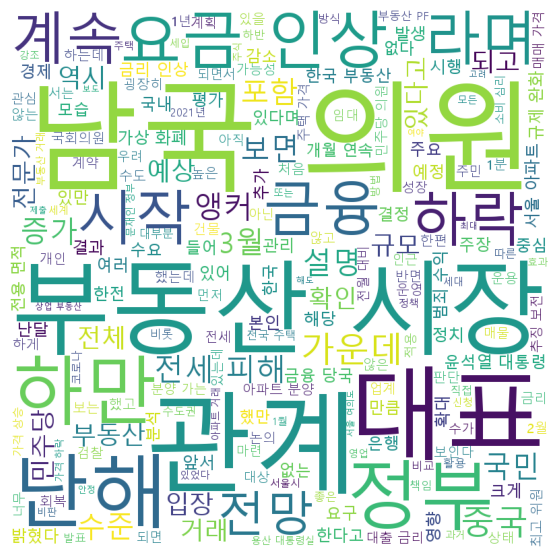

In [149]:
cloud = WordCloud(font_path = font_path, background_color = 'white', 
                  width=800, height=800) # WordCloud 객체 생성
my_cloud2 = cloud.generate_from_text(부동산_content) # 주어진 텍스트로부터 워드클라우드 생성
arr2 = my_cloud2.to_array() # 워드클라우드 이미지를 배열 형태로 변환

fig = plt.figure(figsize=(7,7))# 새로운 그림(fig) 생성, 크기는 7x7
plt.imshow(arr2)  # 이미지를 출력
plt.axis('off')  # 축 제거
plt.show() # 그림 출력
fig.savefig('부동산_wordcloud.png') # 그림을 파일로 저장

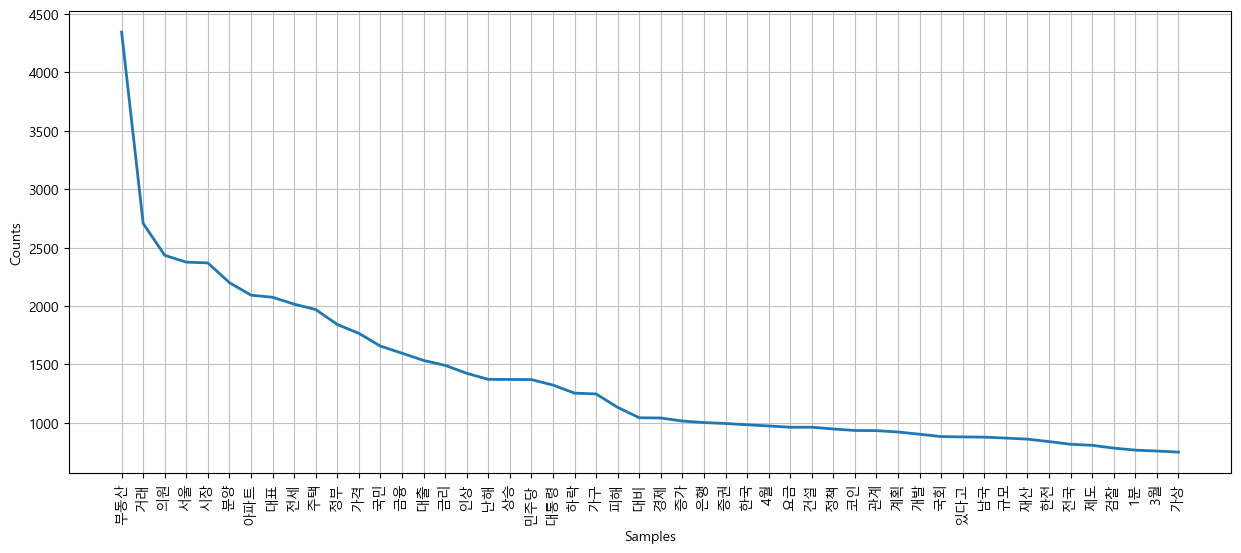

In [150]:
# 주어진 텍스트를 형태소 단위로 분석하여 토큰화
tokens_부동산 = t.morphs(부동산_content)  
# 토큰화된 형태소들을 nltk.Text 객체로 생성
ko = nltk.Text(tokens_부동산)  
# 새로운 그림(fig) 생성, 크기는 15x6
plt.figure(figsize=(15, 6)) 
# 가장 빈도가 높은 상위 50개 단어에 대해 그래프로 출력
ko.plot(50)  
plt.show() 

- Search Word : 전세

In [151]:
#content전부 합쳐서 하나의 string으로 통합
전세_content = ''
전세_data = preprocess_news_data[preprocess_news_data['search_word']=='전세'].reset_index(drop=True)
for _, row in 전세_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    전세_content += str(row['preprocess_context'])

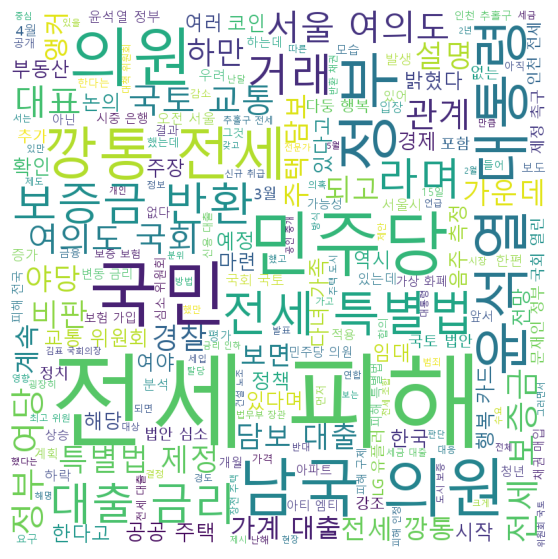

In [152]:
my_cloud2 = cloud.generate_from_text(전세_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('전세_wordcloud.png')

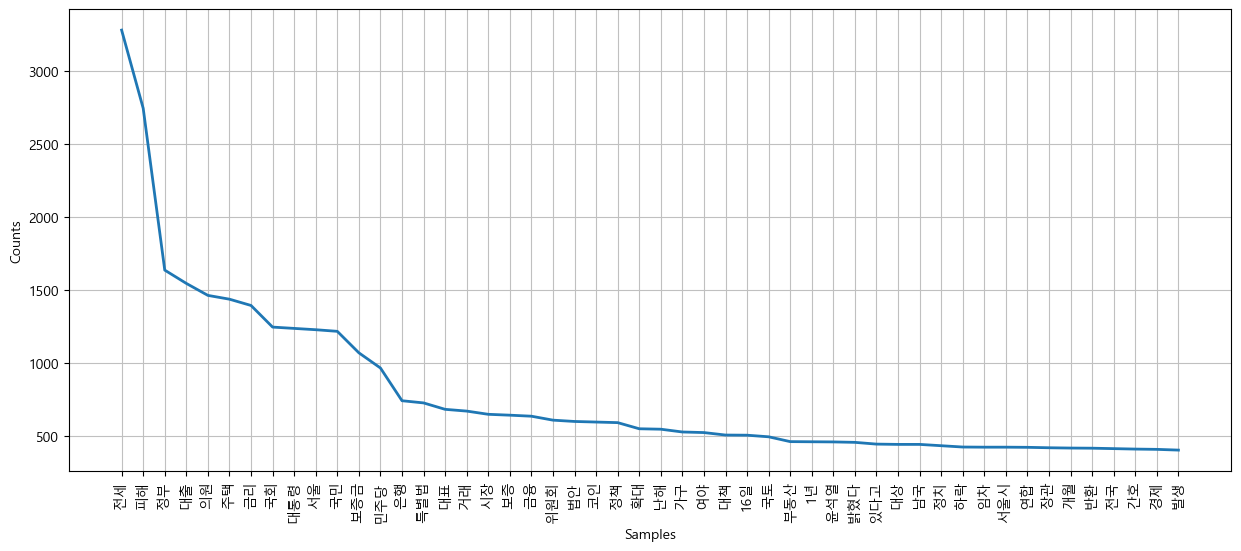

In [153]:
tokens_전세 = t.morphs(전세_content)
ko = nltk.Text(tokens_전세)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 월세

In [154]:
#content전부 합쳐서 하나의 string으로 통합
월세_content = ''
월세_data = preprocess_news_data[preprocess_news_data['search_word']=='월세'].reset_index(drop=True)
for _, row in 전세_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    월세_content += str(row['preprocess_context'])

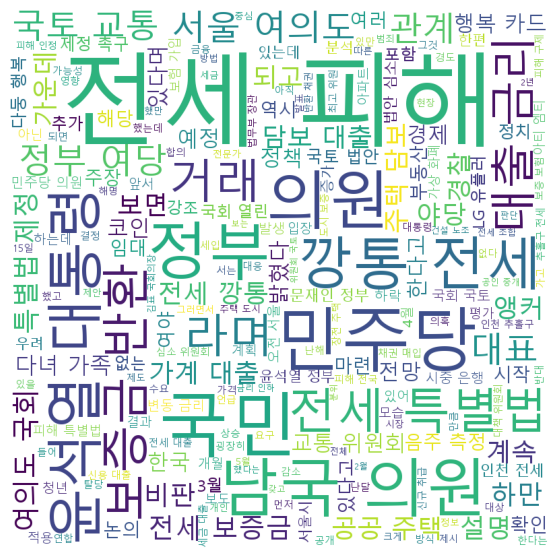

In [155]:
my_cloud2 = cloud.generate_from_text(월세_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('월세_wordcloud.png')

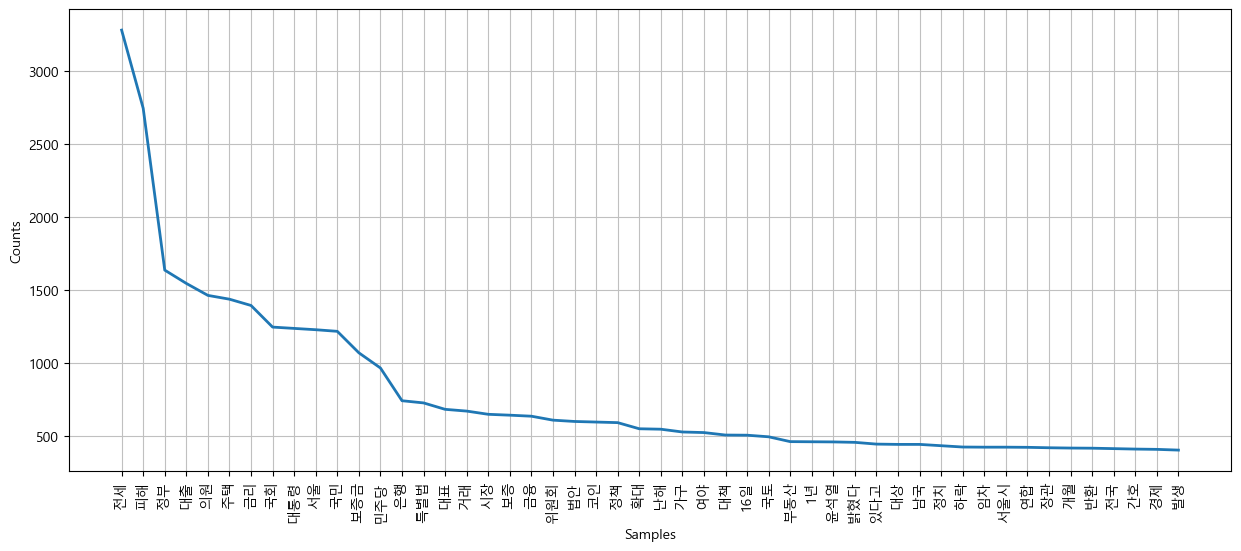

In [156]:
tokens_월세 = t.morphs(월세_content)
ko = nltk.Text(tokens_월세)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 아파트

In [157]:
#content전부 합쳐서 하나의 string으로 통합
아파트_content = ''
아파트_data = preprocess_news_data[preprocess_news_data['search_word']=='아파트'].reset_index(drop=True)
for _, row in 아파트_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    아파트_content += str(row['preprocess_context'])

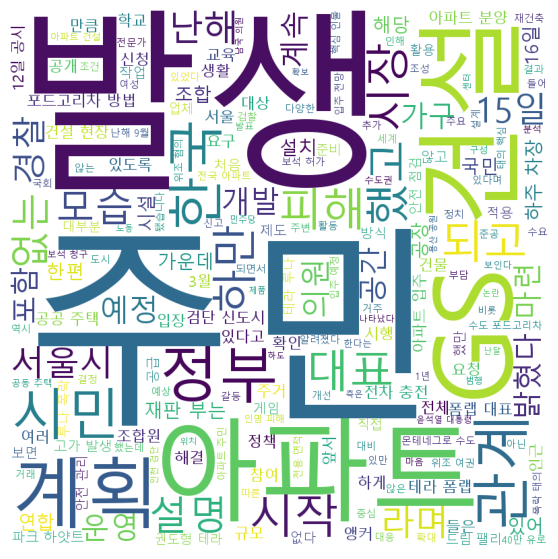

In [158]:
my_cloud2 = cloud.generate_from_text(아파트_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('아파트_wordcloud.png')

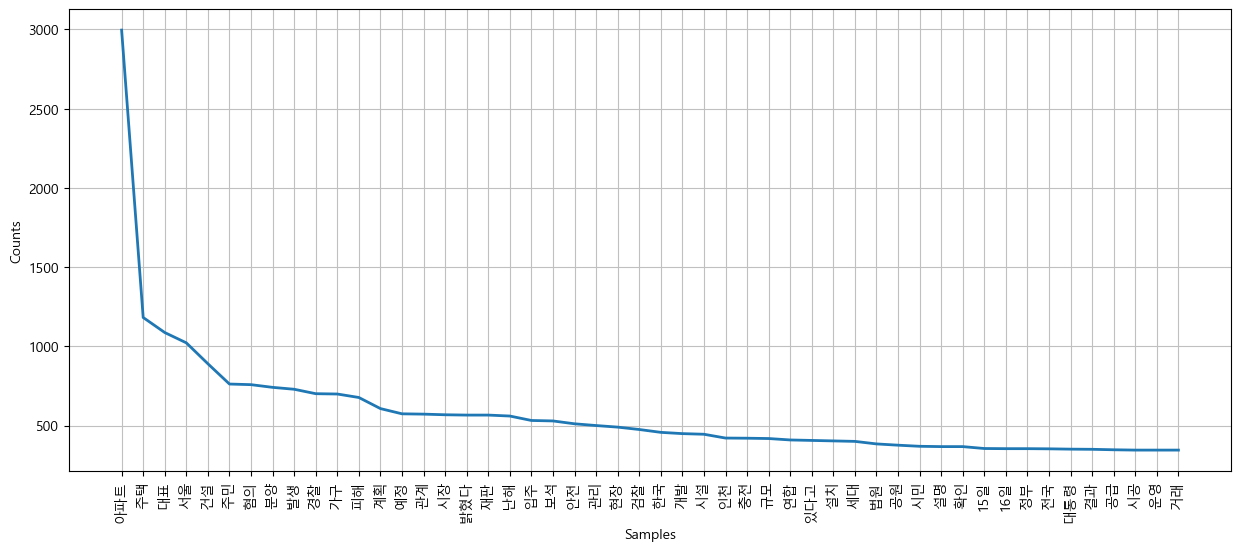

In [159]:
tokens_아파트 = t.morphs(아파트_content)
ko = nltk.Text(tokens_아파트)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 대출

In [160]:
#content전부 합쳐서 하나의 string으로 통합
대출_content = ''
대출_data = preprocess_news_data[preprocess_news_data['search_word']=='대출'].reset_index(drop=True)
for _, row in 대출_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    대출_content += str(row['preprocess_context'])

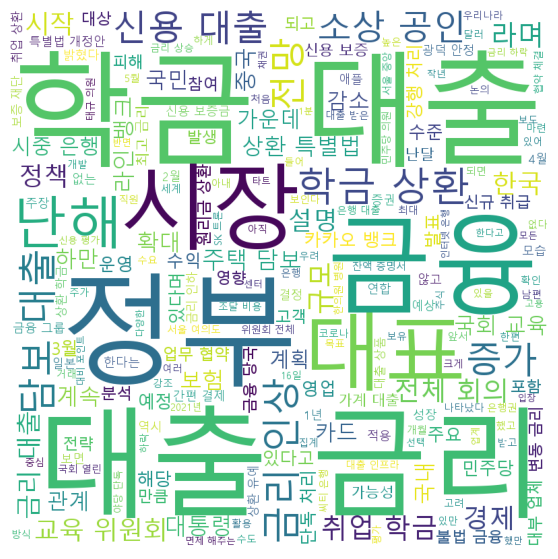

In [161]:
my_cloud2 = cloud.generate_from_text(대출_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('대출_wordcloud.png')

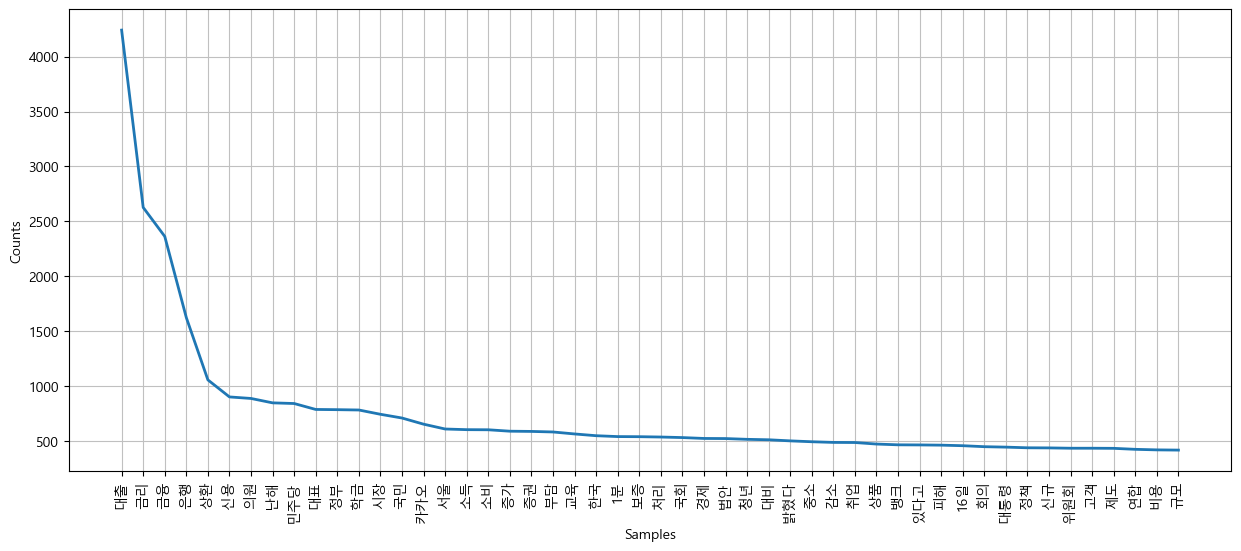

In [162]:
tokens_대출 = t.morphs(대출_content)
ko = nltk.Text(tokens_대출)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 주식

In [163]:
#content전부 합쳐서 하나의 string으로 통합
주식_content = ''
주식_data = preprocess_news_data[preprocess_news_data['search_word']=='주식'].reset_index(drop=True)
for _, row in 전세_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    주식_content += str(row['preprocess_context'])

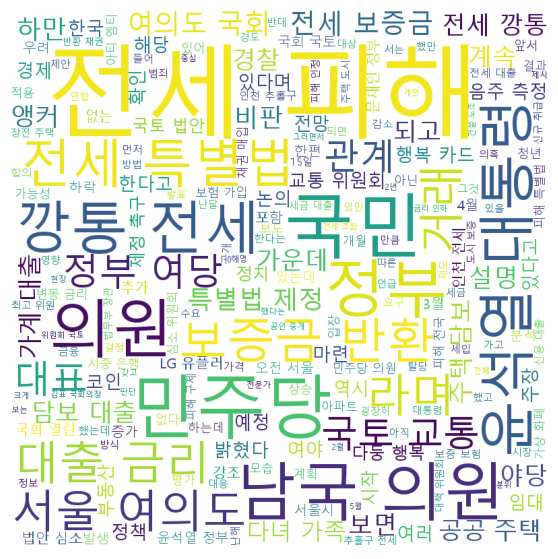

In [164]:
my_cloud2 = cloud.generate_from_text(주식_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('주식_wordcloud.png')

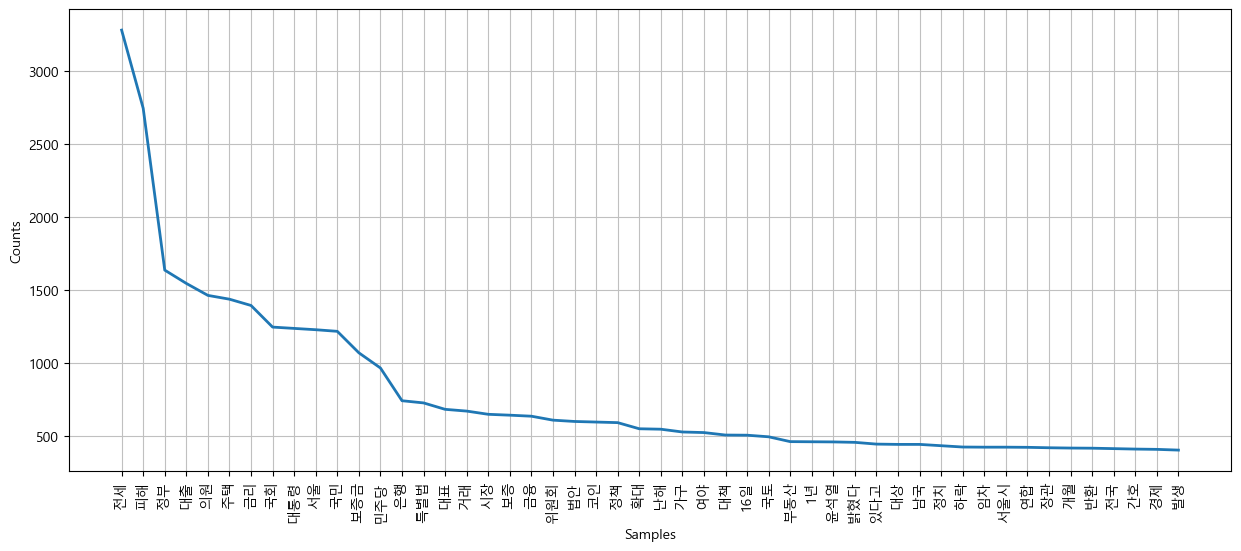

In [165]:
tokens_주식 = t.morphs(주식_content)
ko = nltk.Text(tokens_주식)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 채권

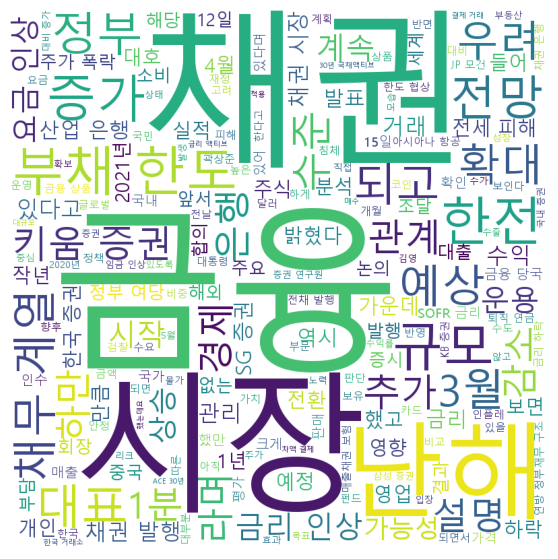

In [166]:
#content전부 합쳐서 하나의 string으로 통합
채권_content = ''
채권_data = preprocess_news_data[preprocess_news_data['search_word']=='채권'].reset_index(drop=True)
for _, row in 채권_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    채권_content += str(row['preprocess_context'])
my_cloud2 = cloud.generate_from_text(채권_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('채권_wordcloud.png')   

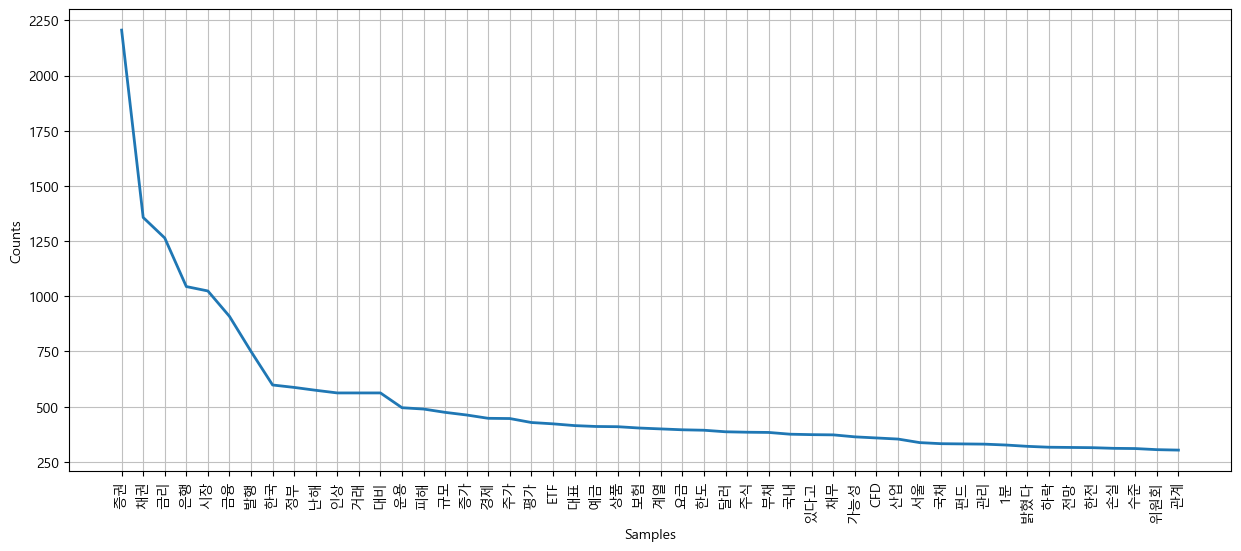

In [167]:
tokens_채권 = t.morphs(채권_content)
ko = nltk.Text(tokens_채권)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 코스피

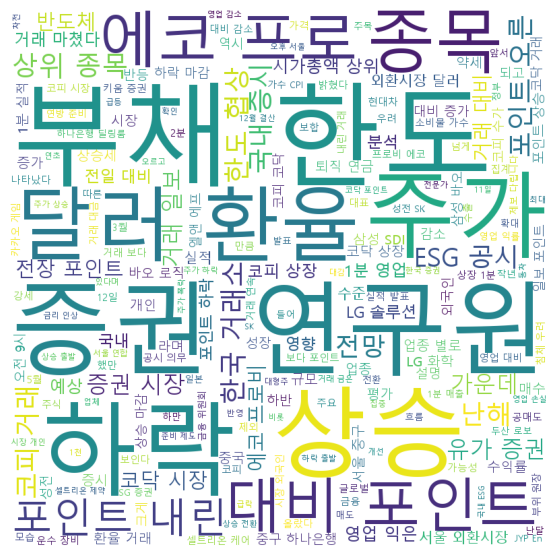

In [168]:
#content전부 합쳐서 하나의 string으로 통합
코스피_content = ''
코스피_data = preprocess_news_data[preprocess_news_data['search_word']=='코스피'].reset_index(drop=True)
for _, row in 코스피_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    코스피_content += str(row['preprocess_context'])
my_cloud2 = cloud.generate_from_text(코스피_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('코스피_wordcloud.png')   

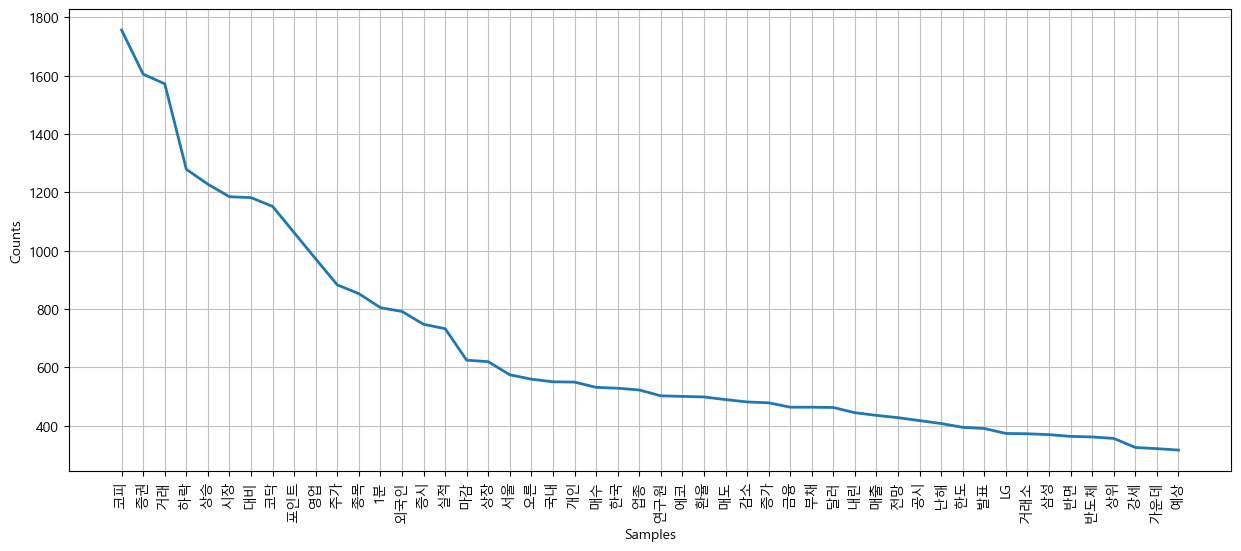

In [169]:
tokens_코스피 = t.morphs(코스피_content)
ko = nltk.Text(tokens_코스피)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 금리

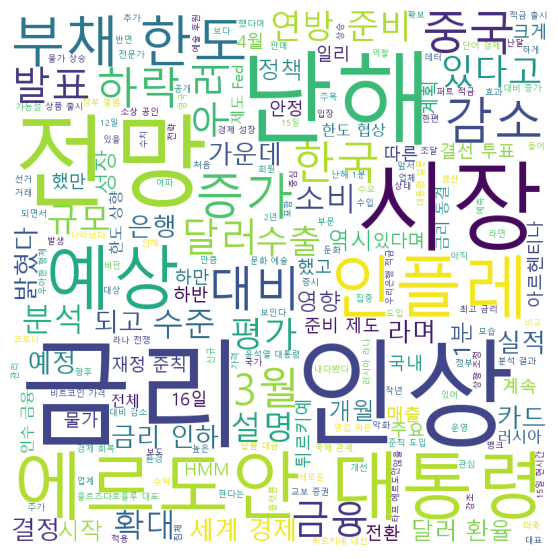

In [170]:
#content전부 합쳐서 하나의 string으로 통합
금리_content = ''
금리_data = preprocess_news_data[preprocess_news_data['search_word']=='금리'].reset_index(drop=True)
for _, row in 금리_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    금리_content += str(row['preprocess_context'])
my_cloud2 = cloud.generate_from_text(금리_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('금리_wordcloud.png')   

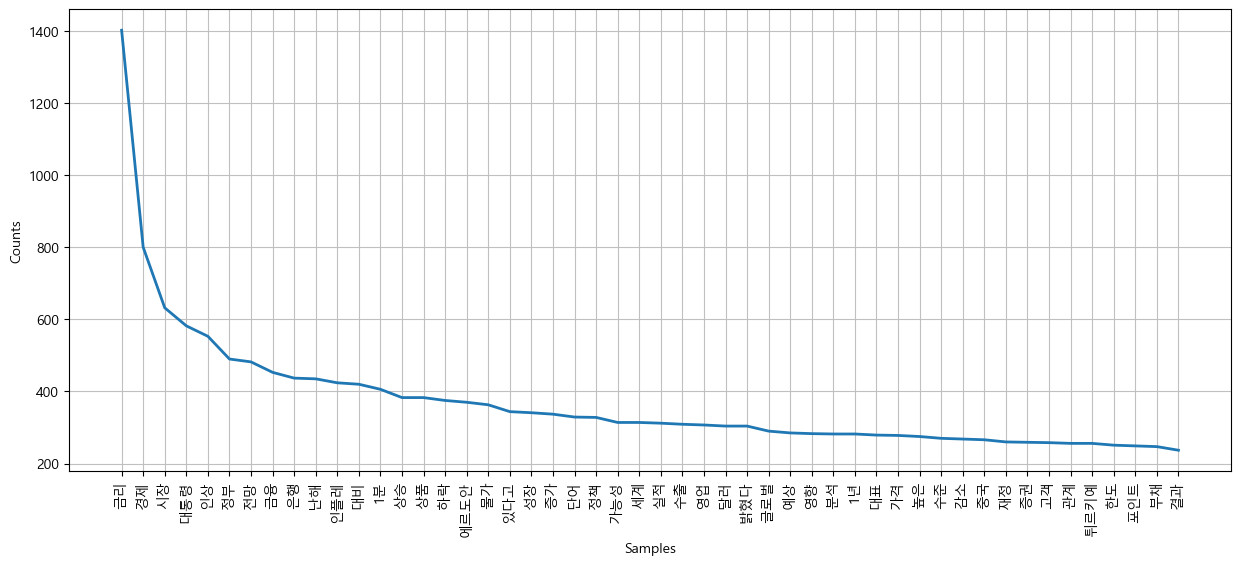

In [171]:
tokens_금리 = t.morphs(금리_content)
ko = nltk.Text(tokens_금리)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

- Search Word : 투자

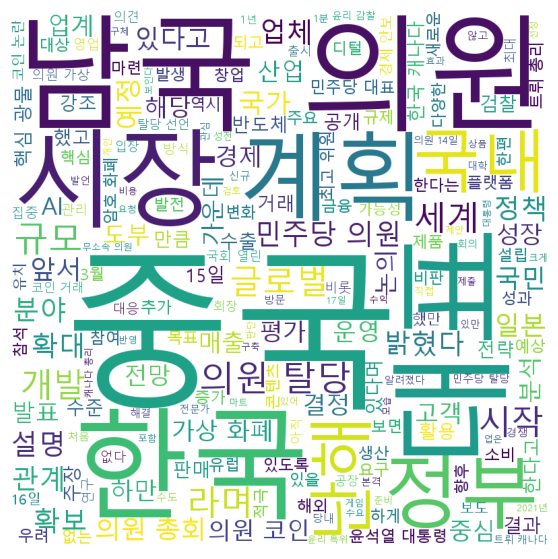

In [172]:
#content전부 합쳐서 하나의 string으로 통합
투자_content = ''
투자_data = preprocess_news_data[preprocess_news_data['search_word']=='투자'].reset_index(drop=True)
for _, row in 투자_data.iterrows():
    # Check if the value of preprocess_context is a float
    if isinstance(row['preprocess_context'], float):
        # If it is, convert it to an empty string
        row['preprocess_context'] = ''
    투자_content += str(row['preprocess_context'])
my_cloud2 = cloud.generate_from_text(투자_content)
arr2 = my_cloud2.to_array()
fig = plt.figure(figsize=(7, 7))
plt.imshow(arr2)
plt.axis('off')
plt.show()
fig.savefig('투자_wordcloud.png')   

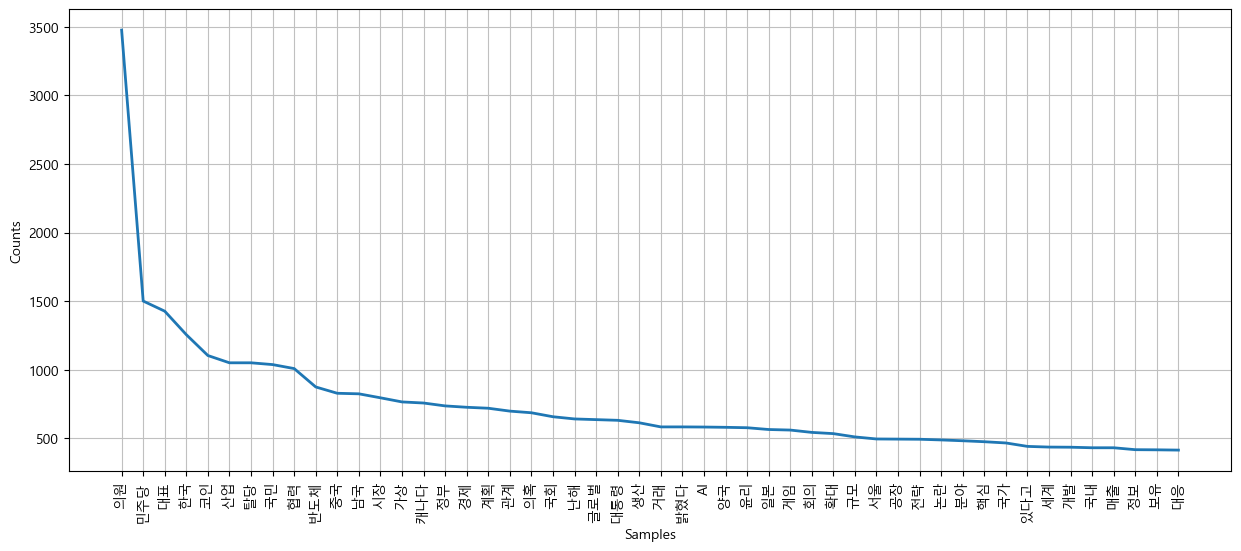

In [173]:
tokens_투자 = t.morphs(투자_content)
ko = nltk.Text(tokens_투자)
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

### 3-2. Text Classification

- (1) TF_IDF벡터화 : 중요한 단어에 가중치를 주며 벡터화

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer() # TF-IDF 벡터화를 위한 TfidfVectorizer 객체 생성
# 'preprocess_context' 열을 기반으로 TF-IDF 행렬 생성
tfidf_mat = tfidf.fit_transform(preprocess_news_data['preprocess_context']) 

In [15]:
tfidf_mat.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

- TF_IDF + Logistic Regression모델

In [16]:
#tfidf행렬과 타겟 변수를 준비
X = tfidf_mat.toarray() #tfidf행렬을 밀집 행렬로 변환
y = preprocess_news_data['search_word'].to_numpy() #타켓 변수를 넘파이 배열로 변환
#train, test 분리
x_trn, x_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#10개로 구분해야하는 멀티클래스분류 이므로 multi_class='auto'사용
model = LogisticRegression(multi_class='auto')
model.fit(x_trn, y_trn) #모델 학습
y_pred = model.predict(x_tst) #모델 예측
print('accuracy_score : ',accuracy_score(y_tst, y_pred)) #평가지표 : 정확도

C:\Users\SAMSUNG\anaconda3\envs\textdata\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy_score :  0.7636096125551741


- TF_IDF + Scale + Logistic Regression모델

In [8]:
from sklearn.preprocessing import StandardScaler

# 스케일러 생성
scaler = StandardScaler()

# 스케일 조정
x_trn_sclaed = scaler.fit_transform(x_trn)
x_tst_scaled = scaler.transform(x_tst)

#10개로 구분해야하는 멀티클래스분류 이므로 multi_class='auto'사용
model = LogisticRegression(multi_class='auto')
model.fit(x_trn_sclaed, y_trn)
y_pred = model.predict(x_tst_scaled)
print('accuracy_score : ',accuracy_score(y_tst, y_pred))

C:\Users\SAMSUNG\anaconda3\envs\textdata\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy_score :  0.7366356056890633


=> scale 진행 후 성능 감소했으므로 성능 개선에 효과 없다고 판단

- (2) CounteVectorizer벡터화 : 각 문서에 어떤 단어가 몇 번 등장했는지 count

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()# CountVectorizer 객체 생성
# 'preprocess_context' 열을 기반으로 벡터화하여 문서-단어 행렬 생성
count_mat = vector.fit_transform(preprocess_news_data['preprocess_context'])
count_mat

<10191x91903 sparse matrix of type '<class 'numpy.int64'>'
	with 1660946 stored elements in Compressed Sparse Row format>

- CountVectorizer + Logistic Regression모델

In [8]:
#count_mat행렬과 타켓 변수를 준비
X = count_mat.toarray() #count_mat행렬을 밀집 행렬로 변환
y = preprocess_news_data['search_word'].to_numpy() # 타겟 변수를 넘파이 배열로 변환합
# train과 test 데이터로 분리
x_trn, x_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, stratify=y)

In [11]:
# 10개로 구분해야하는 멀티클래스 분류를 위해 multi_class='auto'를 사용하여 모델을 생성
model = LogisticRegression(multi_class='auto')
# 모델을 훈련 데이터에 맞추어 학습
model.fit(x_trn, y_trn)
# 학습된 모델을 사용하여 테스트 데이터를 예측
y_pred = model.predict(x_tst)
# 예측 결과와 실제 레이블을 비교하여 정확도를 계산
accuracy = accuracy_score(y_tst, y_pred)
print('accuracy_score: ', accuracy)

C:\Users\SAMSUNG\anaconda3\envs\textdata\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy_score:  0.7935262383521334


=> TF_IDF보다 CounterVectorizer의 성능이 더 좋게 나타났으므로 벡터화 방법으로 선택

- CountVectorizer + naive_bayes 모델

In [128]:
from sklearn.naive_bayes import MultinomialNB
# 나이브 베이즈 모델 생성
naive_bayes = MultinomialNB()
# 모델을 훈련 데이터에 맞추어 학습
naive_bayes.fit(x_trn, y_trn)
# 학습된 모델을 사용하여 테스트 데이터를 예측
y_pred = naive_bayes.predict(x_tst)
# 예측 결과와 실제 레이블을 비교하여 정확도 계산
accuracy = accuracy_score(y_tst, y_pred) ;print("Accuracy:", accuracy)

Accuracy: 0.5610593428151054


- CountVectorizer + RamdomForest 모델

In [112]:
from sklearn.ensemble import RandomForestClassifier
# 랜덤 포레스트 모델 생성
rgb = RandomForestClassifier()
# 모델을 훈련 데이터에 맞추어 학습
rgb.fit(x_trn, y_trn)
# 학습된 모델을 사용하여 테스트 데이터를 예측
y_pred = rgb.predict(x_tst)
# 예측 결과와 실제 레이블을 비교하여 정확도 계산
accuracy = accuracy_score(y_tst, y_pred) ;print("Accuracy:", accuracy)

Accuracy: 0.8249141736145169


- CountVectorizer + LightGBM모델

In [113]:
import lightgbm as lgb
# LightGBM 모델 생성
lgbm = lgb.LGBMClassifier()
# 모델을 훈련 데이터에 맞추어 학습
lgbm.fit(x_trn, y_trn)
# 학습된 모델을 사용하여 테스트 데이터를 예측
y_pred = lgbm.predict(x_tst)
# 예측 결과와 실제 레이블을 비교하여 정확도 계산
accuracy = accuracy_score(y_tst, y_pred) 
print("Accuracy:", accuracy)

Accuracy: 0.9225110348209907


### 3-3. Similar document retrieval

- cosine 유사도 행렬

In [114]:
from sklearn.metrics.pairwise import cosine_similarity
# count_mat 입력으로 사용하여 코사인 유사도 행렬을 계산
cosine_sim = cosine_similarity(count_mat, count_mat)
cosine_sim

array([[1.        , 0.02161912, 0.0363651 , ..., 0.00656148, 0.01716576,
        0.07398178],
       [0.02161912, 1.        , 0.03007377, ..., 0.0145606 , 0.01774501,
        0.02243361],
       [0.0363651 , 0.03007377, 1.        , ..., 0.00669349, 0.00380677,
        0.00492198],
       ...,
       [0.00656148, 0.0145606 , 0.00669349, ..., 1.        , 0.10584637,
        0.00408521],
       [0.01716576, 0.01774501, 0.00380677, ..., 0.10584637, 1.        ,
        0.02013584],
       [0.07398178, 0.02243361, 0.00492198, ..., 0.00408521, 0.02013584,
        1.        ]])

- index 매칭

In [115]:
# `preprocess_news_data`에서 'id'와 인덱스를 매핑하여 id_to_index 딕셔너리를 생성
id_to_index = {k: v for k, v in zip(preprocess_news_data['id'], preprocess_news_data.index)}

# id_to_index 딕셔너리의 키와 값의 순서를 바꾸어 index_to_id 딕셔너리를 생성
index_to_id = {v: k for k, v in id_to_index.items()}

# `preprocess_news_data`에서 'id'와 'title'을 매핑하여 id_to_title 딕셔너리를 생성
id_to_title = {k: v for k, v in zip(preprocess_news_data['id'], preprocess_news_data['title'])}

# id_to_title 딕셔너리의 키와 값의 순서를 바꾸어 title_to_id 딕셔너리를 생성
title_to_id = {v: k for k, v in id_to_title.items()}

In [116]:
id_to_index = {k:v for k,v in zip(preprocess_news_data['id'], preprocess_news_data.index)}
index_to_id = {v:k for k,v in id_to_index.items()}
id_to_title = {k:v for k,v in zip(preprocess_news_data['id'], preprocess_news_data['title'])}
title_to_id = {v:k for k,v in id_to_title.items()}

In [117]:
print('10에 해당하는 id : ',index_to_id[10])
print('11 id에 해당하는 기사 제목 : ',id_to_title[11])

10에 해당하는 id :  11
11 id에 해당하는 기사 제목 :  ‘문재인입니다’ 본 文부부에 전여옥 “국민은 업보 감당 중인데 ‘표 샀다’...


- cosine similarity기준 본문이 가장 유사한 5개 기사 추츨

In [118]:
def get_top5_similarity(news_title, cosine_sim):
    # title --> id --> index
    news_id = title_to_id[news_title]
    idx = id_to_index[news_id]
    
    # 다음과 같은 형식의 리스트를 생성
    # sim_score = [(0, 유사도(기준뉴스, 뉴스0)), (1, 유사도(기준뉴스, 뉴스1)), ...]
    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    # sim_score = [(10, 유사도(기준뉴스, 뉴스10)), (131, 유사도(기준뉴스, 뉴스131)), ...]
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    # 유사도 상위 5개를 선택 (자기 자신은 제외)
    # top5_movies = [(10, 유사도(기준뉴스, 뉴스10)), (131, 유사도(기준뉴스, 뉴스131)), ...]
    top5_news = sim_score[1:6] #0번 인덱스인 자기자신은 제외하고 1번째부터 출력
    
    # 유사도 상위 5개를 선택
    # top5_news = [10, 131, 52, ...]
    top5_news = [x[0] for x in top5_news]
    print(top5_news)
    
    # 위 index에 해당하는 뉴스 id를 산출
    top5_news = [index_to_id[x] for x in top5_news]
    
    # 위 id에 해당하는 뉴스 title을 산출
    top5_news = [id_to_title[_id] for _id in top5_news]

    return top5_news

In [120]:
get_top5_similarity('아파트 거래절벽 여전…서울 단지 4곳 중 3곳 올해 거래 0건', cosine_sim)

[56, 346, 4646, 1535, 129]


['2000가구 월계 아파트 올 거래 전무…부족한 거래량,아직 먼 반등세',
 "잠실 '엘·리·트' 다시 21억원대로…서울 집값 바닥 다졌나",
 '아파트값 바닥 다졌나… 서울 실거래가 3개월 연속 올라',
 "'집값 바닥 찍었나' 서울 아파트 신고가 비율 올 들어 최대",
 '트리지움·헬리오 2억원 상승...서울 아파트값 바닥 찍었나']

In [121]:
get_top5_similarity('SG발 폭락사태 시총 13조 증발…금감원 장외파생 감독 구멍', cosine_sim)

[137, 170, 156, 5805, 7861]


['SG발 폭락사태 3주만에…관련주 시총 13조 증발',
 'SG발 폭락사태 시총 13조 증발…9개 종목 시총 60% 사라져(종합)',
 "SG발 폭락사태 시총 3주 만에 '13조 증발'",
 'SG發 폭락사태에 9개 종목·증권株 시총 13조 증발',
 'SG발 폭락사태 시총 13조 증발…금감원 관리감독 구멍']

### 3-4. Topic Modeling(LDA)

- 각 행에 있는 기사 본문 토큰화

In [122]:
from konlpy.tag import Okt

# 빈 리스트를 생성
tok_li = []
# Okt 객체를 생성
okt = Okt()
# 'preprocess_context' 열을 반복하면서 형태소 분석을 수행하고 결과를 tok_li 리스트에 추가
for i in preprocess_news_data['preprocess_context']:
    tok = okt.morphs(i)
    tok_li.append(tok)

# tok_li 리스트를 이용하여 DataFrame을 생성
df_tok = pd.DataFrame({'preprocess_context': tok_li})
df_tok

,preprocess_context
0,"[2023년, 5월, 15일, 띠별, 운세, 쥐띠, 혼란, 가운데, 드디어, 평안,..."
1,"[성원, 정치, 2019년, 4월, 헌법재판관, 후보, 청문회, 후보, 억대, 주식..."
2,"[양세형, 제주도, 매물, 찾을, 쉬운, 방법, 5월, 14일, 방송, MBC, 예..."
3,"[요금, 인상, 발표, 앞둔, 14일, 서울, 마포구, 건물, 계량, 정부, 여당,..."
4,"[코리안리, 보험, 보유, 비중, 확대, GS, 리테일, 편의점, 비율, 늘어가구,..."
...,...
10186,"[체류, 짧고, 가족, 동반, 불허, 시안, 인력, 수급, 탈피, 시급, 17일, ..."
10187,"[50, 소형, 주택, 학교, 부담, 면제, 공항, 출국, 내는, 출국, 납부, 면..."
10188,"[청주, 산업, 청주시, 청주시, 반도체, 화단, 유치, 총력, 청주시, 해당, 부..."
10189,"[갈등, 마트, 직격탄, 신업, DX, 시장, 개척, 중소, 상공, 솔루션, 공국,..."


- LDA모델을 사용해서 문서 집합을 토픽으로 분류

In [ ]:
import gensim
from gensim import corpora

# df_tok의 'preprocess_context' 열로부터 단어 사전(word_dict)을 생성
word_dict = corpora.Dictionary(df_tok['preprocess_context'])

# 각 문서를 단어의 출현 빈도 표현인 BOW(Bag-of-Words) 형태로 변환하여 corpus를 생성
corpus = [word_dict.doc2bow(text) for text in df_tok['preprocess_context']]

- LDA모델 훈련(10개의 topic설정)

In [124]:
# 토픽의 개수를 지정
N_TOPICS = 10

# LDA(Latent Dirichlet Allocation) 모델을 생성
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=N_TOPICS, id2word=word_dict, passes=15)

# 각 토픽의 단어들을 출력
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.036*"대통령" + 0.021*"정부" + 0.015*"국민" + 0.010*"윤석열"')
(1, '0.016*"증권" + 0.011*"금융" + 0.009*"시장" + 0.007*"중국"')
(2, '0.008*"혐의" + 0.005*"경찰" + 0.005*"아파트" + 0.005*"피해"')
(3, '0.009*"건설" + 0.009*"분양" + 0.008*"인천" + 0.008*"가구"')
(4, '0.030*"전세" + 0.019*"피해" + 0.015*"주택" + 0.014*"대출"')
(5, '0.010*"앵커" + 0.006*"518" + 0.006*"보면" + 0.004*"계속"')
(6, '0.045*"의원" + 0.019*"코인" + 0.018*"민주당" + 0.014*"가상"')
(7, '0.015*"협력" + 0.014*"캐나다" + 0.013*"한국" + 0.010*"양국"')
(8, '0.013*"인상" + 0.013*"요금" + 0.011*"계획" + 0.010*"발전"')
(9, '0.018*"금리" + 0.013*"하락" + 0.012*"상승" + 0.012*"대비"')


- 문서 별 토픽 분포 보기

In [126]:
for i, topic_list in enumerate(ldamodel[corpus]): #corpus의 각 문서에 대해 LDA모델의 토픽 비중 순회
    print(f'{i}번째 문서의 topic 비중: {topic_list}') #각 문서의 인덱스와 토픽 비중 출력
    if i==4: #5번째 문서까지 출력
        break

0번째 문서의 topic 비중: [(0, 0.01976581), (1, 0.030493764), (2, 0.24600169), (5, 0.614415), (7, 0.08685086)]
1번째 문서의 topic 비중: [(0, 0.10518486), (1, 0.043478835), (2, 0.2696419), (5, 0.09108518), (6, 0.47554445), (9, 0.013438907)]
2번째 문서의 topic 비중: [(1, 0.029816847), (2, 0.32329467), (3, 0.090350196), (4, 0.1373538), (5, 0.37526894), (7, 0.040877774)]
3번째 문서의 topic 비중: [(0, 0.12256725), (1, 0.031882934), (2, 0.04344619), (5, 0.038225316), (6, 0.029885236), (8, 0.7324081)]
4번째 문서의 topic 비중: [(1, 0.33516842), (3, 0.025136346), (9, 0.63109034)]


- LDA 시각화

In [125]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Jupyter Notebook에서 시각화를 활성화
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, word_dict) # LDA 모델의 결과를 pyLDAvis 형식으로 변환
pyLDAvis.display(vis)# 시각화 결과를 출력

C:\Users\SAMSUNG\anaconda3\envs\textdata\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


- 각 문서에 대한 topic 비중의 수 확인

In [127]:
def get_topic_ratio_for_each_document(ldamodel, corpus):
    results = []
    for i, topic_list in enumerate(ldamodel[corpus]):
        # 토픽 비중을 내림차순으로 정렬
        sorted_topic_list = sorted(topic_list, key = lambda x: x[1], reverse=True)
        
        # 가장 비중이 높은 토픽과 그 토픽의 비중을 가져옴
        most_important_topic, most_important_ratio = sorted_topic_list[0]
        
        # 문서 번호, 가장 비중이 높은 토픽, 가장 높은 토픽의 비중, 각 토픽의 비중을 저장
        doc_result = [i, most_important_topic, most_important_ratio, sorted_topic_list]
        results.append(doc_result)
        
    results = pd.DataFrame(results, columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중'])
    return results

# 각 문서에 대한 가장 비중이 높은 토픽과 그 토픽의 비중을 추출하여 DataFrame으로 반환
df_results = get_topic_ratio_for_each_document(ldamodel, corpus)
df_results

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,5,0.614418,"[(5, 0.6144182), (2, 0.24602348), (7, 0.086858..."
1,1,6,0.475545,"[(6, 0.47554475), (2, 0.26964203), (0, 0.10518..."
2,2,5,0.375270,"[(5, 0.37526977), (2, 0.32329494), (4, 0.13735..."
3,3,8,0.732409,"[(8, 0.7324093), (0, 0.122567825), (2, 0.04344..."
4,4,9,0.631090,"[(9, 0.63109), (1, 0.3351667), (3, 0.025136355)]"
...,...,...,...,...
10186,10186,7,0.348632,"[(7, 0.34863174), (3, 0.14949273), (9, 0.13413..."
10187,10187,8,0.642600,"[(8, 0.64259976), (4, 0.35109806)]"
10188,10188,3,0.581446,"[(3, 0.5814461), (7, 0.22530825), (8, 0.18884)]"
10189,10189,7,0.562847,"[(7, 0.56284684), (1, 0.40745398), (3, 0.02770..."
